# Imports

In [1]:
import os
from itertools import product

import ipywidgets
import matplotlib.pyplot as plt
import napari
import numpy as np
import pandas as pd
import seaborn as sns
import trackpy as tp
from pims import ND2Reader_SDK, pipeline
from scipy import ndimage as ndi
from skimage.filters import gaussian, median, threshold_otsu
from skimage.measure import label, regionprops
from tqdm.notebook import tqdm

BEADS_CHANNEL = 1
MT_CHANNEL = 0

# Load data & preprocessing

## Data loading

/home/liboyan/miniconda3/envs/mt/lib/python3.10/site-packages/pims/base_frames.py:478: UserWarning: Please call FramesSequenceND.__init__() at the start of thethe reader initialization.
  warn("Please call FramesSequenceND.__init__() at the start of the"


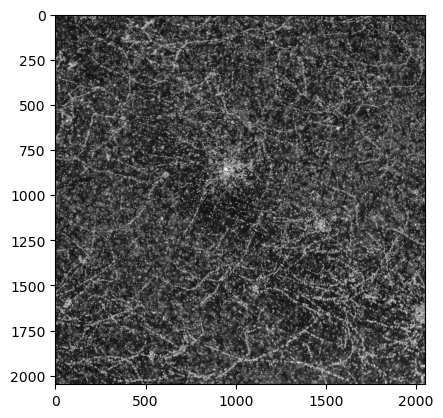

In [2]:
data_dir = "../data/220930/"
data_file = "220930_0.2um-beads003.nd2"  # "220930_1um-beads.nd2"  #
frames = ND2Reader_SDK(os.path.join(data_dir, data_file))
frames.bundle_axes = "cyx"
timepoints = {i: frames[i].metadata["t_ms"] / 1e3 for i in range(len(frames))}
mpp = frames[0].metadata["mpp"]
plt.imshow(frames[0][BEADS_CHANNEL, :, :] * 10, cmap="Greys_r")

## Preprocess

In [4]:
@pipeline
def processing_beads_channel(frame, median_filter_size=3):
    bead_im = median(frame, np.ones((median_filter_size, median_filter_size)))
    return bead_im


@pipeline
def processing_mt_channel(frame):
    mt_im = frame[MT_CHANNEL, :, :]
    return mt_im


beads_frames = frames[0]

# Extract features

## Test different feature sizes

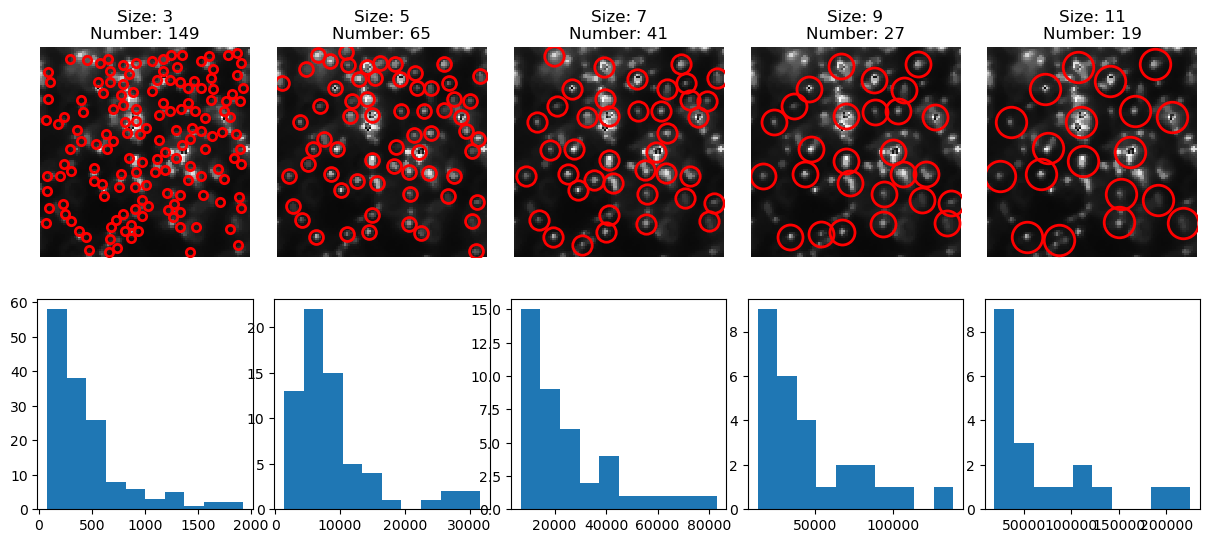

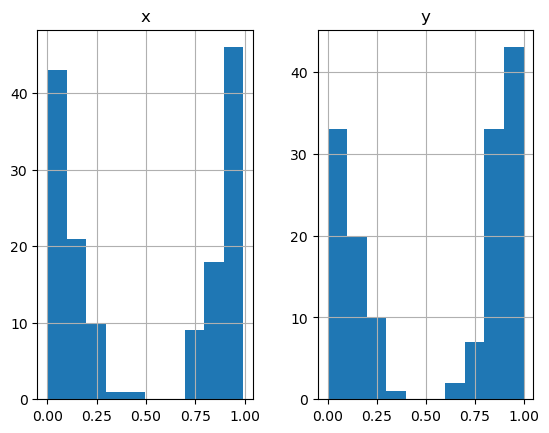

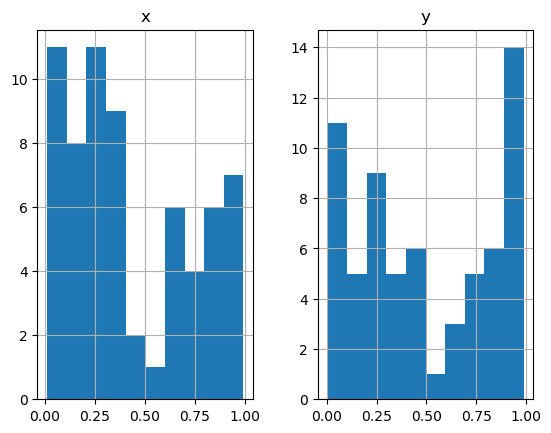

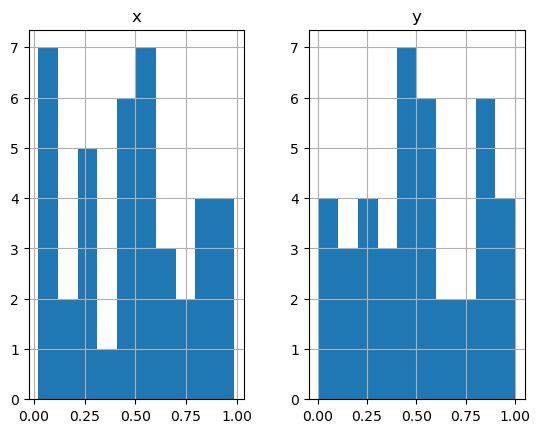

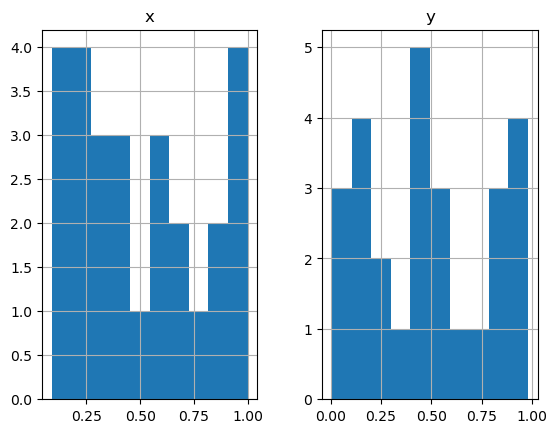

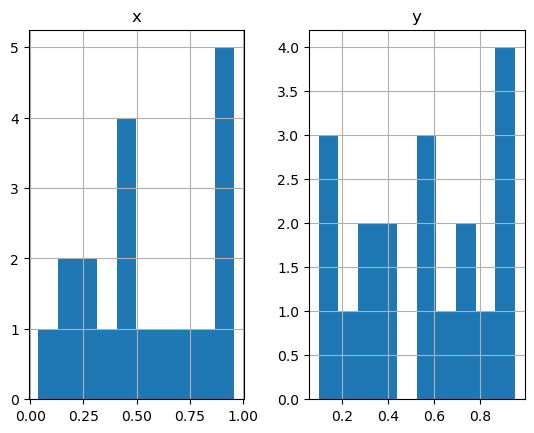

In [4]:
_, ax = plt.subplots(2, 5, figsize=(15, 6))
plt.subplots_adjust(wspace=0.1)
foi = beads_frames[0][900:1000, 900:1000]
for i, s in enumerate([3, 5, 7, 9, 11]):
    f = tp.locate(foi, s, invert=False)
    ax[0, i].set_title("Size: %d\nNumber: %d" % (s, len(f)))
    tp.annotate(f, foi * 5, ax=ax[0, i], invert=False, plot_style={"markersize": s * 2})
    ax[0, i].axis("off")
    ax[1, i].hist(f.mass)
    tp.subpx_bias(f)

## Determine the size threshold

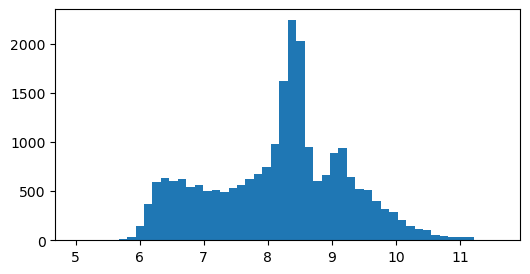

In [5]:
BEAD_SIZE = 5
f = tp.locate(beads_frames[0], BEAD_SIZE, invert=False)
_, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.hist(np.log(f.mass), bins=50);

<AxesSubplot: title={'center': 'Without size filtering: 83'}>

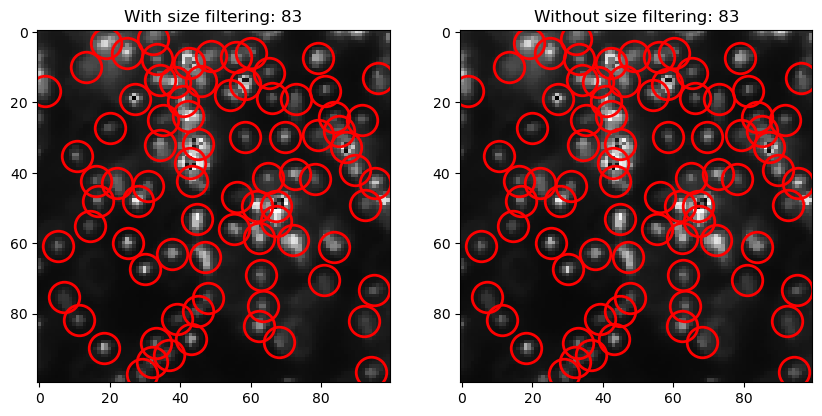

In [6]:
min_mass = np.exp(5)

_, ax = plt.subplots(1, 2, figsize=(10, 5))
f = tp.locate(foi, BEAD_SIZE, invert=False, minmass=min_mass, separation=BEAD_SIZE - 1)
tp.annotate(f, foi * 5, ax=ax[0], plot_style={"markersize": s * 2})
ax[0].set_title("With size filtering: %d" % (len(f)))
f = tp.locate(foi, BEAD_SIZE, invert=False, separation=BEAD_SIZE-1)
ax[1].set_title("Without size filtering: %d" % (len(f)))
tp.annotate(f, foi * 5, ax=ax[1], plot_style={"markersize": s * 2})

## Locate features on all frames

In [7]:
t = tp.batch(
    beads_frames,
    BEAD_SIZE,
    minmass=min_mass,
    separation=BEAD_SIZE-1,
    engine="numba",
)

Frame 240: 35131 features


## Visualize feature distribution

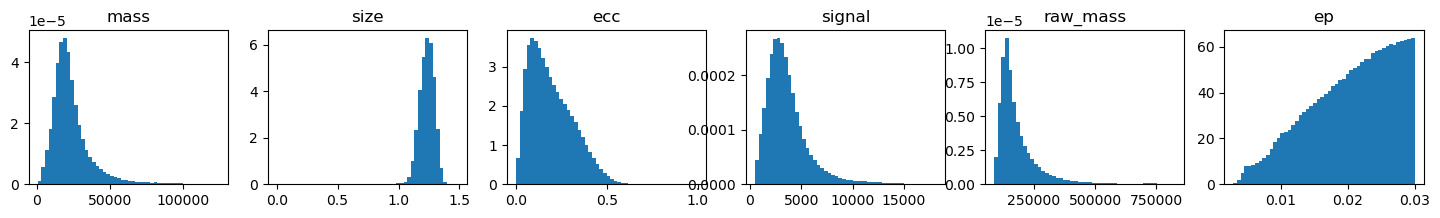

In [26]:
_, ax = plt.subplots(1, len(t.columns) - 3, figsize=((len(t.columns) - 3) * 3, 2))
plt.subplots_adjust(hspace=1)
i = 0
for col in t.columns:
    if col == "x" or col == "y" or col == "frame":
        continue

    if col == "ep":
        ax[i].hist(t[(t[col] > 0) & (t[col] < 0.1)][col], density=True, bins=50)
    elif col == "ecc":
        ax[i].hist(t[(t[col] >= 0) & (t[col] < 1)][col], density=True, bins=50)
    else:
        ax[i].hist(t[col], density=True, bins=50)
    ax[i].set_title(col)
    i += 1

## Filter the spots based on signal

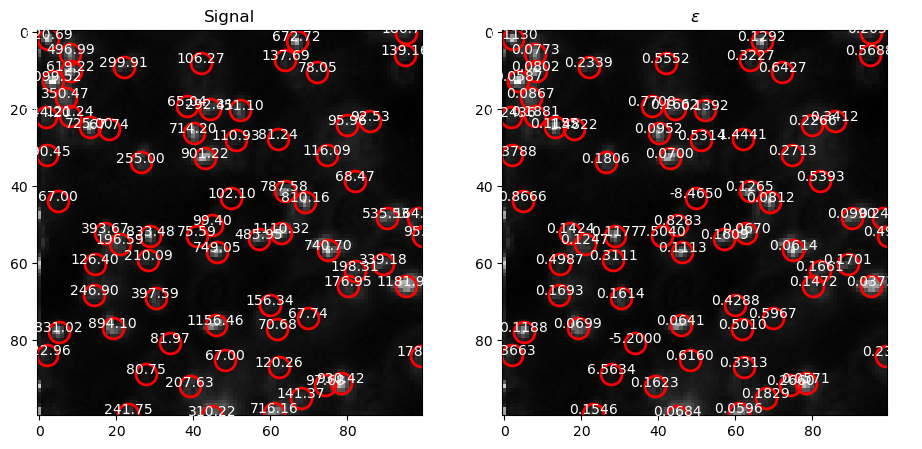

In [21]:
xstart, xend, ystart, yend = 0, 100, 100, 200
foi = frames[0][BEADS_CHANNEL, ystart:yend, xstart:xend]
_, ax = plt.subplots(1, 2, figsize=(11, 5))
t_partial = t[
    (t.frame == 0) & (t.y < yend) & (t.y > ystart) & (t.x > xstart) & (t.x < xend)
].copy()
t_partial.x = t_partial.x.apply(lambda x: x - xstart)
t_partial.y = t_partial.y.apply(lambda y: y - ystart)
tp.annotate(t_partial, foi * 5, ax=ax[0])
tp.annotate(t_partial, foi * 5, ax=ax[1])
for x, y, s, ep in zip(t_partial.x, t_partial.y, t_partial.signal, t_partial.ep):
    ax[0].text(x, y, "%.2f" % s, c="white", ha="center")
    ax[1].text(x, y, "%.4f" % ep, c="white", ha="center")
    ax[0].set_title("Signal")
    ax[1].set_title("$\epsilon$")

(0.0, 0.2)

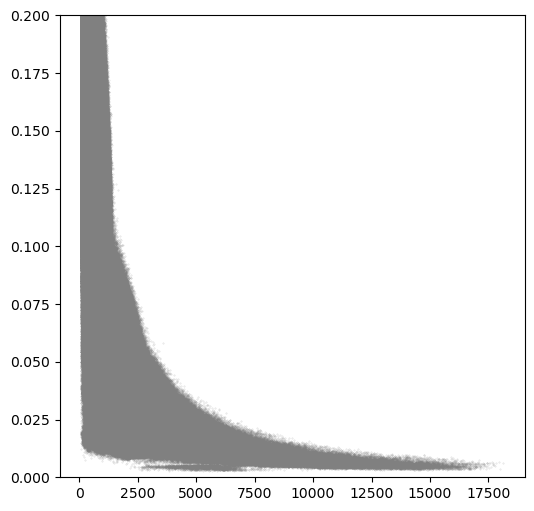

In [22]:
_, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(t[t.ep > 0].signal, t[t.ep > 0].ep, c="grey", s=0.1, alpha=0.3)
ax.set_ylim([0, 0.2])

In [23]:
t = t[(t.ep < 0.03) & (t.signal > 500) & (t.signal < 300)]

# Link all features

## Link

In [24]:
tp.linking.Linker.MAX_SUB_NET_SIZE = 100
search_range = 5
tf = tp.link(t, search_range, memory=1)

Frame 240: 2741 trajectories present.


## Filter spurious trajectories

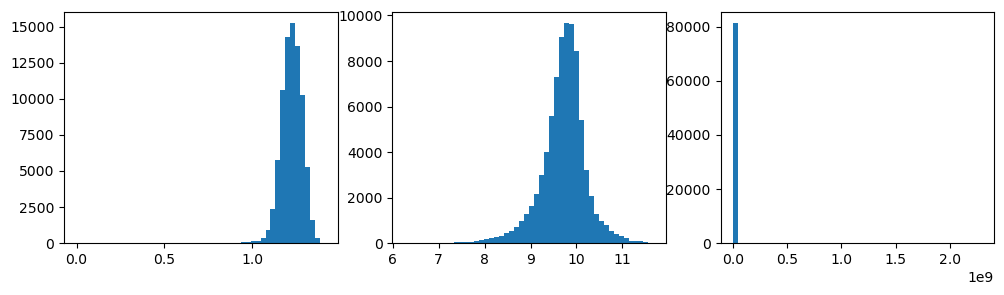

In [25]:
_, ax = plt.subplots(1, 3, figsize=(12, 3))
ax[0].hist(tf.groupby("particle").mean()["size"], bins=50)
ax[1].hist(np.log(tf.groupby("particle").mean().mass), bins=50)
ax[2].hist(tf.groupby("particle").mean().ecc, bins=50);

Before filtering: 3103,	After filtering: 1406


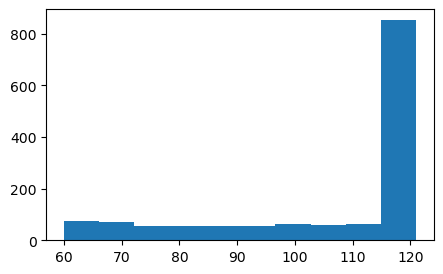

In [14]:
tf1 = tp.filter_stubs(tf, len(frames) // 2)
print(
    f"Before filtering: {tf.particle.nunique()},\tAfter filtering: {tf1.particle.nunique()}"
)

_, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.hist(tf1.groupby("particle").apply(len));

## Visualize the trajectory

In [17]:
xstart, xend, ystart, yend = 1000, 1200, 1000, 1200
tf1_partial = tf1[
    (tf1.y < yend) & (tf1.y > ystart) & (tf1.x > xstart) & (tf1.x < xend)
].copy()
tf1_partial.x = tf1_partial.x - xstart
tf1_partial.y = tf1_partial.y - ystart
frames.iter_axes = "c"
frames.bundle_axes = "tyx"

traj = list(zip(tf1_partial.particle, tf1_partial.frame, tf1_partial.y, tf1_partial.x))
viewer = napari.view_image(frames[BEADS_CHANNEL][:, xstart:xend, ystart:yend])
viewer.add_tracks(traj, name="tracks")

<Tracks layer 'tracks' at 0x7f2e46c762c0>

## Substract global drift

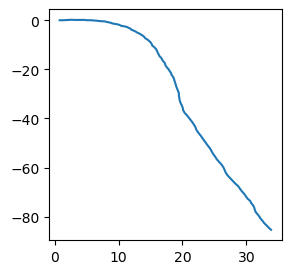

In [20]:
d = tp.compute_drift(tf1)
_, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.plot(d.y, d.x)

In [21]:
tf2 = tp.subtract_drift(tf1.copy(), d)
d.columns = [s + "_drift" for s in d.columns]
tf2 = tf2.merge(d, how="left", left_index=True, right_index=True)
tf2 = tf2.fillna(0)

# Determine the locations of centrosome

## Test the thresholding

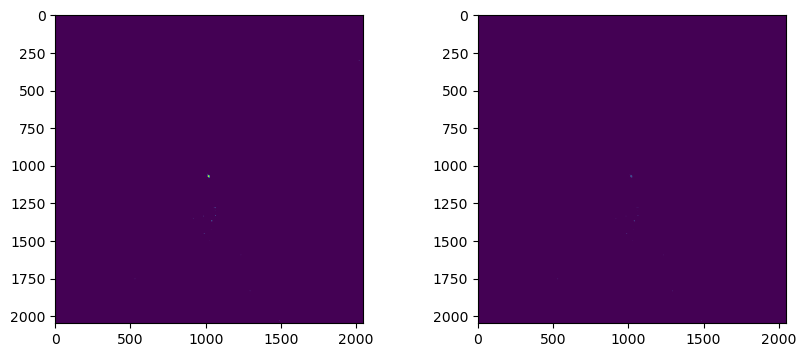

In [41]:
im0 = mt_frames[0]  # beads_frames[0]
thresh_ratio = 4
im = ndi.binary_fill_holes(im0 > threshold_otsu(im0) * thresh_ratio)
label_img = label(im)
_, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(im)
ax[1].imshow(label_img)

## Calculate the centroid of centrosomes

In [42]:
n_centrosome = 1
centrosome_df = pd.DataFrame(
    columns=[
        "centrosome_%d_%s" % (i, ax) for i, ax in product(range(n_centrosome), "xy")
    ]
)
frames.iter_axes = "t"
frames.bundle_axes = "cyx"
for i in tqdm(range(frames.sizes["t"])):
    im0 = frames[i][BEADS_CHANNEL, :, :]
    im = ndi.binary_fill_holes(im0 > threshold_otsu(im0) * thresh_ratio)
    label_img = label(im)
    regions = regionprops(label_img)
    areas = np.array([region.area for region in regions])
    locs = np.array(
        [list(regions[i].centroid) for i in areas.argsort()[-n_centrosome:]]
    )
    locs = locs[locs[:, 0].argsort(), :] * mpp
    new_dict = {
        "centrosome_%d_%s" % (i, ax): locs[i, "xy".find(ax)]
        for i, ax in product(range(n_centrosome), "xy")
    }
    centrosome_df = pd.concat([centrosome_df, pd.DataFrame.from_records([new_dict])])
centrosome_df.reset_index(drop=True, inplace=True)

  0%|          | 0/121 [00:00<?, ?it/s]

## MToC trajectory

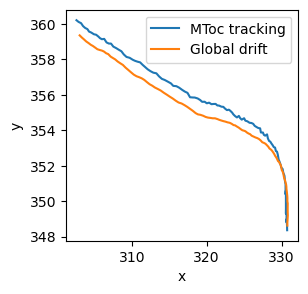

In [44]:
_, ax = plt.subplots(1, n_centrosome, figsize=(3 * n_centrosome, 3))
if n_centrosome == 1:
    ax = [ax]
plt.subplots_adjust(wspace=0.5)
for i in range(n_centrosome):
    sns.lineplot(
        data=centrosome_df,
        x="centrosome_%d_y" % i,
        y="centrosome_%d_x" % i,
        ax=ax[i],
        label="MToc tracking",
    )
    ax[i].plot(
        mpp * d.x_drift + centrosome_df.loc[0, "centrosome_%d_y" % i],
        mpp * d.y_drift + centrosome_df.loc[0, "centrosome_%d_x" % i],
        label="Global drift",
    )
    ax[i].set_xlabel("x")
    ax[i].set_ylabel("y")
    ax[i].legend()

In [45]:
centrosome_robust = True
if not centrosome_robust:
    for col in centrosome_df.columns:
        centrosome_df[col] = centrosome_df.loc[0, col]

# Merge with timepoints and centrosome locations

In [46]:
for col in ["x", "y", "x_drift", "y_drift"]:
    tf2[col] = tf2[col].apply(lambda x: x * mpp)

tf2["t"] = tf2.frame.map(timepoints)
tf2 = tf2.merge(centrosome_df, left_index=True, right_index=True)

if centrosome_robust:
    for col in tf2.columns:
        if col.endswith("_x"):
            tf2[col] -= tf2.y_drift
        elif col.endswith("_y"):
            tf2[col] -= tf2.x_drift
tf2

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,y_drift,x_drift,t,centrosome_0_x,centrosome_0_y
0,478.975668,223.204606,216078.161731,1.767735,0.299407,16539.784310,731847.0,0.004186,0,1,0.000000,0.000000,1.217144,348.366568,330.751522
0,478.350172,115.929770,109323.228630,1.597403,0.281948,10915.499117,359610.0,0.008635,0,2,0.000000,0.000000,1.217144,348.366568,330.751522
0,477.635509,85.782777,77007.535867,1.852046,0.173566,5278.571803,305985.0,0.010195,0,3,0.000000,0.000000,1.217144,348.366568,330.751522
0,477.412929,334.399692,128182.355930,1.602829,0.094250,12206.940413,766032.0,0.003997,0,4,0.000000,0.000000,1.217144,348.366568,330.751522
0,477.218709,277.316754,97445.469601,1.767798,0.136971,7675.226227,362683.0,0.008560,0,5,0.000000,0.000000,1.217144,348.366568,330.751522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,276.440145,487.806981,139184.805403,1.637555,0.071844,12995.267333,459799.0,0.006344,120,700,10.992748,-27.736513,600.988452,349.220704,330.324995
120,275.421333,345.043574,112338.780001,1.762917,0.144192,8794.612330,409017.0,0.007152,120,1322,10.992748,-27.736513,600.988452,349.220704,330.324995
120,275.320284,255.990790,142098.500729,1.577068,0.046467,14537.291712,450059.0,0.006485,120,1782,10.992748,-27.736513,600.988452,349.220704,330.324995
120,274.952336,603.600392,143875.575610,1.581479,0.093397,14516.346618,438050.0,0.006667,120,1583,10.992748,-27.736513,600.988452,349.220704,330.324995


In [ ]:
tp.plot_traj(tf2[tf2.index < 100])

Drawing multicolor lines takes awhile. Come back in a minute.


In [48]:
tf2.to_csv(
    os.path.join(data_dir, data_file[: data_file.rfind(".")] + ".csv"), index=False
)